# Packages

In [ ]:
import nltk
import os
import string
import collections
import re
import numpy as np
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data

In [ ]:
import gzip
# Link Google Drive account, transfer dataset
from google.colab import drive
drive.mount('/content/gdrive')
from shutil import copyfile
copyfile('gdrive/My Drive/Progetto_TMeS/brevetti_class.csv', 'brevetti_class.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'brevetti_class.csv'

In [ ]:
import pandas as pd
data = pd.read_csv('brevetti_class.csv')

In [ ]:
data=data[['description','abstract','topic']]

In [ ]:
print(data.shape)
data.head()

(45027, 3)


,description,abstract,topic
0,one objective of this invention is to provide ...,activated carbon for automobile emission contr...,f
1,the present invention is described with refere...,a hollow cover boot formed of an elastomeric m...,h
2,fig1 is a block diagram showing a sub - sampli...,an image processor for generating a histogram ...,g
3,in a manner similar to that described within t...,this invention relates to a security paper doc...,d
4,referring now to fig1 there is shown an engine...,the present invention relates to engines havin...,f


#PreProcessing

In [ ]:
# Check if there are any NAN values
data.isnull().values.any()

False

In [ ]:
# Case Folding
data['preprocessed'] = data['description'].str.lower()

In [ ]:
# Are there patent with URL? Yes
data[data['preprocessed'].str.contains(r'https?://\S+|www.\.\S+')]

,description,abstract,topic,preprocessed
33615,"as discussed above in the summary , the invent...","the present invention comprises rugged , inexp...",g,"as discussed above in the summary , the invent..."


In [ ]:
# Remove URL
data['preprocessed']=data['preprocessed'].str.replace(r'https?://\S+|www.\.\S+', '')

In [ ]:
# Remove punctuations except dots and commas beacause they will be needed later for Summary
PUNCTUATIONS = string.punctuation

PUNCTUATIONS = PUNCTUATIONS.replace(r'.', '') 
PUNCTUATIONS = PUNCTUATIONS.replace(r',', '') 
PUNCTUATIONS += '$'+'£'+'&'

def remove_punctuation(text):
    trans = str.maketrans(dict.fromkeys(PUNCTUATIONS, ' '))
    return text.translate(trans)

In [ ]:
# Remove Punctuations
data['preprocessed']=data['preprocessed'].map(lambda x: remove_punctuation(x))

In [ ]:
# Create a new dataset specific for summarization
# It will have further and slightly different preprocessing later

data_summarization = data[['abstract', 'topic', 'preprocessed']]

In [ ]:
# Remove numbers
data['preprocessed']=data['preprocessed'].str.replace(r'\d+', '', regex=True)

In [ ]:
# Porter Stemming
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [ ]:
# Definition of white space tokenization and Porter stemming function
def stemSentenceTokenSpace(text):
    #Token are defined by space between words
    token_words=text.split()
    stem_text=""
    for word in token_words:
        # Stemming
        stem_text=stem_text+' '+porter.stem(word)
    # Return string (as input type)
    return stem_text

In [ ]:
# Install and import package Spacy for Lemmatization

# Install spaCy
import sys
!{sys.executable} -m pip install spacy

# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import spacy

#Example of how the spacy model works
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

# Exemple for Spacy Lemmatization
sentence = "The striped bats are hanging on their feet for best. We're living in Milan now."

# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])

'the stripe bat be hang on -PRON- foot for good . -PRON- be live in Milan now .'

In [ ]:
# Definition of spacy lemmatization function
def lemmSentence(text): 
  doc = nlp(text)
  # Extract the lemma for each token and join
  return " ".join([token.lemma_ for token in doc])

In [ ]:
# Apply Space Token and Porter Stemming
data['stem_token_space']=data['preprocessed'].map(lambda x: stemSentenceTokenSpace(x))

In [ ]:
# Apply Lemmatization to text
data['lemm']=data['preprocessed'].map(lambda x: lemmSentence(x))

In [ ]:
# Delete string '-PRON-' from lemm column
data['lemm']=data['lemm'].str.replace(r'-PRON-', '')

In [ ]:
# Definition of a function to remove WhiteSpace
def remove_whitespaces(text):
    return " ".join(text.split())

In [ ]:
# Remove WhiteSpace from the stemming and lemmatization columns
data['stem_token_space']=data['stem_token_space'].map(lambda x: remove_whitespaces(x))
data['lemm']=data['lemm'].map(lambda x: remove_whitespaces(x))

In [ ]:
# Remove words with len<=3 (like 'fig', abbreviations, initials etc.)
data['stem_token_space']=data['stem_token_space'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['lemm']=data['lemm'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
# Save the dataset into a new csv file
data.to_csv('data_preprocessed.csv')

In [ ]:
# Define stopwords
STOPWORDS = stopwords.words('english')

# Add very frequent words in patents
STOPWORDS.extend(['position','step','embodiment','first','product','invention',
                  'process','show','example','within','form','also'])

# Define function for removing stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

In [ ]:
# Removing stopwords from the stemming and lemmatization columns
data['stem_token_space']=data['stem_token_space'].map(lambda x: remove_stopwords(x))
data['lemm']=data['lemm'].map(lambda x: remove_stopwords(x))

In [ ]:
# Save the dataset into a new file
data.to_csv('data_preprocessed_stopwords_class.csv')

In [ ]:
# Function for most common words
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def most_common_wordcloud(text):
  # first 100 most common token
  tokens=text.split()
  most_common=nltk.FreqDist(tokens).most_common(100)
  most_common_dict = dict(most_common)
  
  # visualize
  wordcloud = WordCloud(height=400, width=800)
  wordcloud.generate_from_frequencies(frequencies=most_common_dict)
  plt.figure(figsize=(15, 15))
  plt.imshow(wordcloud)
  plt.axis("off")

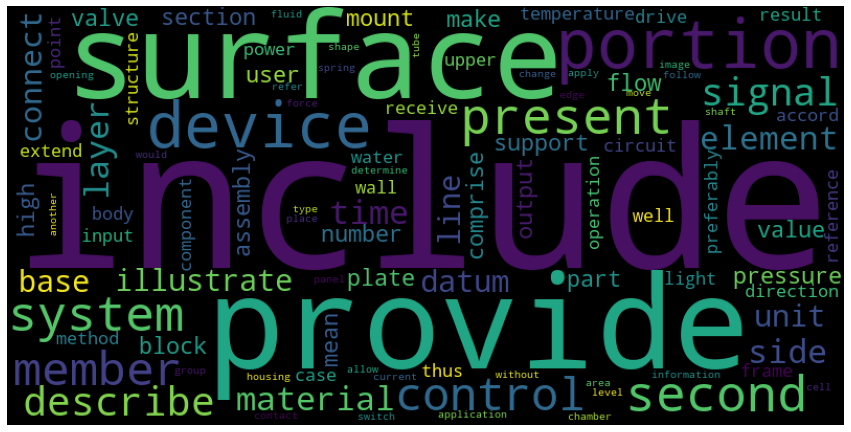

In [ ]:
# Visualization of the 11500 most common words
i = random.sample(list(data.index), 1500)
somma=data['lemm'][i].sum()
most_common_wordcloud(somma)
plt.show()

# Preprocessign for summarization

In [ ]:
# Take only the documents relative to topic b (performing operations, transporting)
data_summarization = data_summarization.loc[data_summarization['topic'] == 'b']
data_summarization.reset_index(drop=True, inplace=True)
# For high computanional cost we consider only the first 2500 patent
data_summarization=data_summarization[:2500]

In [ ]:
print(data_summarization.shape)
data_summarization.head()

(2500, 3)


,abstract,topic,preprocessed
0,a process for controlling a multiple stage dra...,b,"with reference to the drawings , a wire drawin..."
1,"a plastic material , controlled at a desired t...",b,preferred embodiments according to the present...
2,a box formed from a single piece of cardboard ...,b,reference will firstly be made to fig1 which s...
3,"a machine for accurately cutting tiles , block...",b,"fig1 illustrates a block , stone , tile and wo..."
4,the present invention provides a rechargeable ...,b,an illustrative embodiment of the present inve...


In [ ]:
# Create new column with the clean sentences, needed later for the summary
# Apply a simple sentence tokenizer to obtain, for each document, a list of phrases

def clean_sentences(doc):
  sentences = nltk.sent_tokenize(doc)
  return sentences

data_summarization['clean_sentences'] = data_summarization['preprocessed'].map(lambda x: clean_sentences(x))

In [ ]:
# Function to obtain normalized sentences from the clean ones created above
# It's the same preprocessing as before, just applied to the single sentences 

def sentences_normalization(lista):
  normalized_sentences = []
  for phrase in lista:
    #sentences normalization
    phrase = re.sub(r'\d+','', phrase) #remove numbers
    phrase = phrase.strip() #remove white spaces
    
    #create tokens and removing stopwords and short words
    tokens = nltk.word_tokenize(phrase)
    filtered_tokens = [token for token in tokens if token not in STOPWORDS]
    filtered_tokens = [word for word in filtered_tokens if len(word) > 3]

    #create the new preprocessed phrase with all the remaining tokens
    phrase = ' '.join(filtered_tokens)

    #create a new document composed of the list of normalized sentences
    normalized_sentences.append(phrase)

  return normalized_sentences

data_summarization['norm_sentences'] = data_summarization['clean_sentences'].map(lambda x: sentences_normalization(x))

In [ ]:
data_summarization.head()

,abstract,topic,preprocessed,clean_sentences,norm_sentences
0,a process for controlling a multiple stage dra...,b,"with reference to the drawings , a wire drawin...","[with reference to the drawings , a wire drawi...",[reference drawings wire drawing system machin...
1,"a plastic material , controlled at a desired t...",b,preferred embodiments according to the present...,[preferred embodiments according to the presen...,[preferred embodiments according present descr...
2,a box formed from a single piece of cardboard ...,b,reference will firstly be made to fig1 which s...,[reference will firstly be made to fig1 which ...,[reference firstly made shows spread piece pun...
3,"a machine for accurately cutting tiles , block...",b,"fig1 illustrates a block , stone , tile and wo...","[fig1 illustrates a block , stone , tile and w...",[illustrates block stone tile wood cutting app...
4,the present invention provides a rechargeable ...,b,an illustrative embodiment of the present inve...,[an illustrative embodiment of the present inv...,[illustrative present described detail referen...


In [ ]:
# Save csv for later use in the summarization part
data_summarization.to_csv('/content/gdrive/MyDrive/Progetto_TMeS/data_summarization.csv')